
# Telecom Churn (Cease) Project — Exploratory Data Analysis

This notebook performs a **business-focused EDA** for the UK Telecoms cease/churn assessment.

## Business objective
Prioritise retention effort by identifying customers most likely to **place a cease** (leave) soon, so the retention team can focus calls on higher-risk customers.

## Data sources used
- `cease` 
- `customer_info` 
- `calls` 
- `usage` 


## 1) Setup and imports

In [2]:

# Core imports
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import duckdb
import warnings
from pathlib import Path
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', 200)
pd.set_option('display.width', 180)

### Quick Preview of all dataset

In [3]:
#Create a connection to the duckdb database
catalog_db = duckdb.connect("UK_telecom.duckdb")


# Quick preview of calls file
calls_csv_preview = catalog_db.execute("""
    SELECT *
    FROM read_csv_auto('../data/calls.csv')
    LIMIT 100
""").df()

print("CSV preview:")
print(calls_csv_preview)

CSV preview:
                           unique_customer_identifier event_date call_type  talk_time_seconds  hold_time_seconds
0   aae0258b41e6e88365d7d5ce648ea69d837602b4bb419e... 2023-02-22   Loyalty              627.0              235.0
1   15f9f6fc1872bbf6963a84de253d600e5d18d75d7784ce... 2023-03-16      Tech              267.0              293.0
2   c18d59888cb050a5694d1e613a277d79b4a3083bd1b813... 2023-02-22   Loyalty              689.0                0.0
3   1316da4b4282f98b572666413a71592352cc869c976212... 2023-03-16      Tech             3233.0                0.0
4   6f33a33df6e18900a60d495eb19f2c7b238a13ec5cd894... 2023-03-16      Tech                2.0                0.0
..                                                ...        ...       ...                ...                ...
95  b17a215acd1cd25604e0b6732680eaf3fd15d68e9db661... 2023-03-16      Tech              424.0                0.0
96  0e5b159902fe768b4cc1b80e211522695e8e7ebffc2ad6... 2023-03-16      Tech         

In [4]:
#Create a connection to the duckdb database
catalog_db = duckdb.connect("UK_telecom.duckdb")


# Quick preview of cease file
cease_csv_preview = catalog_db.execute("""
    SELECT *
    FROM read_csv_auto('../data/cease.csv')
    LIMIT 100
""").df()

print("CSV preview:")
print(cease_csv_preview)

CSV preview:
                           unique_customer_identifier cease_placed_date cease_completed_date                     reason_description reason_description_insight
0   03b1c584533a86d067dd51bbca242db2b55b692f10d325...        2023-08-03           2023-09-04  Competitor Deals - No longer required            CompetitorDeals
1   97a7bdce317de91a32636e6675bbb2e5b25573308ef7bb...        2023-08-03           2023-09-04                                  Cease                VagueReason
2   c5049a1aedc36d7d7379c2c2144972b099521e6614cf8c...        2023-08-03           2023-09-05  Competitor Deals - No longer required            CompetitorDeals
3   cffa7eecb1708776f425a0f1e70598710b5e74a66d8fea...        2023-08-03           2023-08-21                              Not Known                VagueReason
4   f450c8a916d400b204b0228fa23bf613ceae5727e08a68...        2023-08-03           2023-09-04  Competitor Deals - No longer required            CompetitorDeals
..                               

In [5]:
# Quick preview of customer_info parquet file
customer_info_preview = catalog_db.execute("""
    SELECT *
    FROM read_parquet('../data/customer_info.parquet')
    LIMIT 100
""").df()

print("Parquet preview:")
customer_info_preview.tail(10)

Parquet preview:


,unique_customer_identifier,datevalue,contract_status,contract_dd_cancels,dd_cancel_60_day,ooc_days,technology,speed,line_speed,sales_channel,crm_package_name,tenure_days
90,7113b840dabb8224fde90ff25217acfbef4fb55a904ce1...,2024-06-01,01 Early Contract,0,0,-464,FTTC,65,58.364000,Migrated Customer,Fibre 65 (FTTC-OR),5608
91,3a04caa130b62e474c4bbcac5a3ab2dfc6002593263249...,2023-11-01,02 In Contract,0,0,-221,FTTC,65,75.956000,Online - Ambient,Fibre 65 (FTTC-OR),2469
92,fe7be4f4d5685b5085ddfa564b35e419d2dab768380460...,2023-12-01,03 Soon to be OOC,0,0,-63,FTTC,35,39.997000,Online - Affiliate,Fibre 35 (FTTC-OR),2353
93,bde98b50ca6b44cdbe4c6727a718646d2ad1c8dbc787b3...,2024-01-01,02 In Contract,0,0,-431,FTTC,65,49.525000,Migrated Customer,Fibre 65 (FTTC-OR),5908
94,64ae1867c8fafcad80af72855af3ccd61944cffd1ff810...,2023-01-01,01 Early Contract,0,0,-715,FTTC,35,29.209584,Migrated Customer,Fibre 35 (FTTC-OR),6815
95,7c3e411532d6ca0d03ff25440f56e4c72002abe6a91ba0...,2023-09-01,04 Coming OOC,0,0,-17,MPF,18,14.409180,Unknown,Fast Broadband,5324
96,066c39e667a512aefc28a2a1326eb4ada0ab5ceaa90c87...,2023-11-01,06 OOC,0,0,119,FTTC,65,45.783000,Unknown,Fibre 65 (FTTC-OR),5293
97,35583a0190aebcc9f485feb53dd670056b1cea6a7a086f...,2024-06-01,06 OOC,0,0,100,FTTC,65,66.635000,Migrated Customer,Fibre 65 (FTTC-OR),5324
98,414e79d2dd18d01b238ebba5c4539cd363bed9be2d2053...,2023-03-01,05 Newly OOC,0,0,43,FTTC,65,79.999000,Migrated Customer,Fibre 65 (FTTC-OR),5552
99,c820d47689b6792335bfb3dee1eec3007aa5af4915fe78...,2024-07-01,06 OOC,0,0,2759,MPF,18,39.806000,Migrated Customer,Plus TV Access Everything with Fibre,6229


In [6]:
# Quick preview of usage parquet file
usage_preview = catalog_db.execute("""
    SELECT *
    FROM read_parquet('../data/usage.parquet')
    LIMIT 100
""").df()

print("Parquet preview:")
usage_preview.head(10)

Parquet preview:


,unique_customer_identifier,calendar_date,usage_download_mbs,usage_upload_mbs
0,9a87ea1d3811ec1b9c78d9fd12365648ba2203508545c6...,2022-09-22,9860.716,1032.873
1,d03550f4797142c2fe145fcbeb7ec247b7771b5153605d...,2022-09-22,3200.633,151.137
2,ed854191c887a386f417e64bb0814ffa157d147891b070...,2022-09-22,3474.182,106.833
3,1ac8215f9e98d15b235e6baa5b4a45dafa930201348b23...,2022-09-22,16601.283,1510.906
4,17f6b51c5295d23443a9e0736dd2209b76aba82cbef303...,2022-09-22,4788.412,168.129
5,28305b0142631079c8b2fa51149867a143de44b9f303e9...,2022-09-22,13922.517,372.234
6,009496584d3f34d82d40a271a28196abe78f0a73a04050...,2022-09-22,10062.910,445.010
7,6e150f4b6a34ad5b8a47d179847edc343a8286418dd92b...,2022-09-22,182.517,11.934
8,0ea9eddd944adcda453338e543c36eb7a41ca203723d50...,2022-09-22,1624.102,81.300
9,3489760e7b7a97af3af2fceaa7431fc6cd17e5b7b8b8e3...,2022-09-22,2479.076,287.534


 #### Dataset paths

In [21]:
#initializing current working directory
cwd = Path.cwd()
repo_dir = cwd.parent if cwd.name.lower() in {"notebook", "notebooks"} else cwd


output_dir = Path.cwd().parent / "eda_outputs"   # if notebook is inside /notebooks
output_dir.mkdir(parents=True, exist_ok=True)

# Default project data paths (edit if your names differ)
data_dir = repo_dir / "data"
cease_path = data_dir / "cease.csv"
calls_path = data_dir / "calls.csv"
customer_path = data_dir / "customer_info.parquet"
usage_path = data_dir / "usage.parquet"

#### Load Datasets 
#### The datasets provided for this project vary in format and size. To minimize memory overhead during exploratory data analysis, DuckDB was used so queries could be executed directly against the source files without loading entire datasets into Python objects

#### Call & Cease dataset (csv formats)

In [8]:
#Load CSV robustly into pandas + register a DuckDB view."""
def load_table(path:Path, table_name:str, catalog_db:duckdb.DuckDBPyConnection):
    """Load CSV/Parquet robustly into pandas + register a DuckDB view."""
    suffix = path.suffix.lower()
    if suffix == ".csv":
        df = catalog_db.execute(f"""
            SELECT *
            FROM read_csv_auto('{path.as_posix()}')
        """).df()

    else:
        raise ValueError(f"Unsupported file type for {path}")
    
    
    #register dataset and view for SQL exploration
    catalog_db.register(f"{table_name}_df", df)
    catalog_db.execute(f"CREATE OR REPLACE VIEW {table_name} AS SELECT * FROM {table_name}_df")
    return df    


def parse_dates_if_present(df: pd.DataFrame):
    date_like =[c for c in df.columns if "date" in c.lower() or "time" in c.lower()]
    for c in date_like:
        df[c] = pd.to_datetime(df[c], errors='coerce')
    return df

cease = parse_dates_if_present(load_table(cease_path, "cease", catalog_db))
calls = parse_dates_if_present(load_table(calls_path, "calls", catalog_db))




### Data Quality Checks (EDA Foundation)
(a) Cease | Calls dataset


In [9]:
print("Shapes:")
print("cease   :", cease.shape)
print("calls   :", calls.shape)

print(f"***************************************************************")

print(f"info for cease datasets")
cease.info()

print(f"***************************************************************")
print(f"info for calls datasets")
calls.info()

Shapes:
cease   : (146363, 5)
calls   : (628437, 5)
***************************************************************
info for cease datasets
<class 'pandas.DataFrame'>
RangeIndex: 146363 entries, 0 to 146362
Data columns (total 5 columns):
 #   Column                      Non-Null Count   Dtype         
---  ------                      --------------   -----         
 0   unique_customer_identifier  146363 non-null  str           
 1   cease_placed_date           146363 non-null  datetime64[us]
 2   cease_completed_date        119146 non-null  datetime64[us]
 3   reason_description          146363 non-null  str           
 4   reason_description_insight  146363 non-null  str           
dtypes: datetime64[us](2), str(3)
memory usage: 19.2 MB
***************************************************************
info for calls datasets
<class 'pandas.DataFrame'>
RangeIndex: 628437 entries, 0 to 628436
Data columns (total 5 columns):
 #   Column                      Non-Null Count   Dtype        

In [10]:

# Duplicate checks (record-level and key-level)
checks = {
    'calls_row_duplicates': calls.duplicated().sum(),
    'cease_row_duplicates': cease.duplicated().sum(),
    'calls_dup_customer_date': calls.duplicated(['unique_customer_identifier','event_date']).sum(),
}
pd.DataFrame(list(checks.items()), columns=['check','value'])

,check,value
0,calls_row_duplicates,6486
1,cease_row_duplicates,350
2,calls_dup_customer_date,269110


### 

*****************************************************************
#### Observation

<b> Cease Dataset </b>

- 146,363 rows, 5 columns; suitable for event-level churn/cease analysis.

- Strong data quality: all key fields are complete except cease_completed_date (27,217 missing).

- Missing cease_completed_date may carry business meaning (e.g., pending/incomplete ceases) and should be investigated.

- cease_placed_date is the main field for defining the churn/cease target window.

- reason_description and reason_description_insight are useful for churn reason segmentation and explainability.

<b> Cease Dataset : Duplicates </b>
- cease_row_duplicates = 350

- There are 350 fully duplicated rows in the cease dataset.

- Same issue: exact duplicate records.

- Risk: can inflate cease counts and distort target creation if not removed.

<b> Calls Dataset </b>

- 628,437 rows, 5 columns; key dataset for customer interaction/behaviour features.

- High completeness across fields (no visible missing values).

- talk_time_seconds and hold_time_seconds appear to be stored as datetime, not numeric durations — this needs correction before feature engineering.

- Well suited for building rolling behavioural features (e.g., call volume, repeat calls, hold-time metrics, retention/loyalty contact patterns).

<b>Calls Dataset : Duplicates </b>
- calls_row_duplicates = 6,486

- There are 6,486 fully duplicated rows in the calls dataset.

- This means all columns in those rows are identical copies of another row.

- Risk: double-counting call events, inflated call volumes, biased features (e.g., call frequency, hold time totals).



<b> Modelling Readiness (Overall) </b>

- Both datasets are strong foundations for churn modelling with clear identifiers and high completeness.

- Cease data supports target creation and churn reason analysis.

- Calls data provides valuable behavioural signals but requires duration field type conversion.

- Together, they support a robust cease-risk prediction and retention prioritisation workflow.

- Exact row duplicates (calls_row_duplicates, cease_row_duplicates) should usually be removed.

- Customer-date duplicates should be investigated before removal, because they may represent valid multiple same-day interactions.

### 



***************************************************
(b) Customer info | usage dataset (Large Parquet files)

In [11]:


data_dir = Path("../data")
parquet_files = list(data_dir.glob("*.parquet"))

for file_path in parquet_files:
    file_str = file_path.as_posix()

    # Shape
    row_count = catalog_db.execute(f"""
        SELECT COUNT(*) AS n_rows
        FROM read_parquet('{file_str}')
    """).fetchone()[0]

    schema_df = catalog_db.execute(f"""
        DESCRIBE SELECT * FROM read_parquet('{file_str}')
    """).df()

    col_count = len(schema_df)

    # Build non-null / null report per column
    info_rows = []
    for col in schema_df["column_name"].tolist():
        non_null_count = catalog_db.execute(f'''
            SELECT COUNT("{col}") 
            FROM read_parquet('{file_str}')
        ''').fetchone()[0]

        null_count = row_count - non_null_count
        null_pct = (null_count / row_count * 100) if row_count else 0

        col_type = schema_df.loc[schema_df["column_name"] == col, "column_type"].iloc[0]

        info_rows.append({
            "column_name": col,
            "non_null_count": int(non_null_count),
            "null_count": int(null_count),
            "null_pct": round(null_pct, 2),
            "dtype": col_type
        })

    info_df = pd.DataFrame(info_rows)

    # File size (parquet file size on disk)
    file_size_mb = file_path.stat().st_size / (1024 ** 2)

    # Print summary (.info()-like)
    print("\n" + "=" * 80)
    print(f"File: {file_path.name}")
    print(f"Rows: {row_count:,} | Columns: {col_count}")
    print(f"File size (disk): {file_size_mb:.2f} MB")
    print("-" * 80)
    print(info_df.to_string(index=False))


File: customer_info.parquet
Rows: 3,545,538 | Columns: 12
File size (disk): 257.54 MB
--------------------------------------------------------------------------------
               column_name  non_null_count  null_count  null_pct   dtype
unique_customer_identifier         3545538           0      0.00 VARCHAR
                 datevalue         3545538           0      0.00    DATE
           contract_status         3545538           0      0.00 VARCHAR
       contract_dd_cancels         3545538           0      0.00  BIGINT
          dd_cancel_60_day         3545538           0      0.00 INTEGER
                  ooc_days         3526590       18948      0.53 INTEGER
                technology         3545538           0      0.00 VARCHAR
                     speed         3545538           0      0.00 INTEGER
                line_speed         3545538           0      0.00  DOUBLE
             sales_channel         3545538           0      0.00 VARCHAR
          crm_package_name   

### 

*****************************************************************
#### Observation

Key Observations
<b> customer_info.parquet </b>

- Large, high-quality snapshot dataset: 3,545,538 rows × 12 columns (257.54 MB), suitable as the main monthly snapshot table for churn modelling.

- Very strong completeness: 11/12 columns are fully populated.

- Minor missingness: ooc_days has 0.53% nulls (18,948 rows) — low impact, but should be reviewed and handled.

- Strong churn features present: datevalue (snapshot date), contract_status, contract_dd_cancels, dd_cancel_60_day, ooc_days, tenure_days, plus package/channel/service fields.

- Data types are mostly modelling-ready for feature engineering.

<b> usage.parquet </b>

- Very large behavioural dataset: 83,185,050 rows × 4 columns (~2.95 GB), ideal for usage trend and churn-signal engineering.

- Excellent completeness: all columns are 100% populated.

- calendar_date is correctly typed as DATE, enabling rolling-window features (e.g., 7/30/90-day usage).

- Key preprocessing issue: usage_download_mbs and usage_upload_mbs are stored as VARCHAR and must be converted to numeric before analysis/modeling.

- Best handled with DuckDB (or similar) for memory-efficient EDA and aggregations.

<b> Overall Data Readiness </b> 

- Data quality is strong overall and suitable for a robust churn/cease modelling workflow.

- Main preprocessing priorities:

- Handle missing values in ooc_days

- Convert usage fields from VARCHAR to numeric

<b> Modelling roles: </b> 

- customer_info = snapshot anchor dataset

- usage = behavioural feature source (trend/decline/volatility signals)

In [12]:
# Connect to DuckDB
#catalog_db = duckdb.connect("UK_telecom.duckdb")

# Path to your large parquet file
#parquet_path = Path("../data/customer_info.parquet")

customer_path = data_dir / "customer_info.parquet"

# Register a view (no full pandas load)
catalog_db.execute(f"""
    CREATE OR REPLACE VIEW customer AS
    SELECT * FROM read_parquet('{customer_path.as_posix()}')
""")

# Count exact duplicate rows (all columns identical)
dup_summary = catalog_db.execute("""
    WITH row_counts AS (
        SELECT *, COUNT(*) AS row_cnt
        FROM customer
        GROUP BY ALL
    )
    SELECT
        COUNT(*) AS unique_row_groups,
        SUM(CASE WHEN row_cnt > 1 THEN 1 ELSE 0 END) AS duplicate_row_groups,
        SUM(CASE WHEN row_cnt > 1 THEN row_cnt - 1 ELSE 0 END) AS duplicate_extra_rows
    FROM row_counts
""").df()

print(dup_summary)

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

   unique_row_groups  duplicate_row_groups  duplicate_extra_rows
0            3532720               12818.0               12818.0


In [14]:
#Further duplicate check by customer id and datevalue 
# Check duplicates by business key: customer_id + datevalue
dup_customer_date = catalog_db.execute("""
    SELECT
       unique_customer_identifier,
        datevalue,
        COUNT(*) AS cnt
    FROM customer
    GROUP BY unique_customer_identifier, datevalue
    HAVING COUNT(*) > 1
    ORDER BY cnt DESC, unique_customer_identifier, datevalue
""").df()

print("Duplicate unique_customer_identifier + datevalue groups:")
print(dup_customer_date.head(20))
print(f"Total duplicate groups: {len(dup_customer_date)}")

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Duplicate unique_customer_identifier + datevalue groups:
                           unique_customer_identifier  datevalue  cnt
0   0120a0bd056bcd1356098b0d7cdd0bbde39615d9e36f1e... 2022-08-01    2
1   0120a0bd056bcd1356098b0d7cdd0bbde39615d9e36f1e... 2022-09-01    2
2   0120a0bd056bcd1356098b0d7cdd0bbde39615d9e36f1e... 2022-10-01    2
3   0120a0bd056bcd1356098b0d7cdd0bbde39615d9e36f1e... 2022-11-01    2
4   0120a0bd056bcd1356098b0d7cdd0bbde39615d9e36f1e... 2022-12-01    2
5   0120a0bd056bcd1356098b0d7cdd0bbde39615d9e36f1e... 2023-01-01    2
6   0120a0bd056bcd1356098b0d7cdd0bbde39615d9e36f1e... 2023-02-01    2
7   0120a0bd056bcd1356098b0d7cdd0bbde39615d9e36f1e... 2023-03-01    2
8   0120a0bd056bcd1356098b0d7cdd0bbde39615d9e36f1e... 2023-04-01    2
9   0120a0bd056bcd1356098b0d7cdd0bbde39615d9e36f1e... 2023-05-01    2
10  0120a0bd056bcd1356098b0d7cdd0bbde39615d9e36f1e... 2023-06-01    2
11  0120a0bd056bcd1356098b0d7cdd0bbde39615d9e36f1e... 2023-07-01    2
12  0120a0bd056bcd1356098b0d7cdd0

### 

*****************************************************************
#### Observation

- The duplication level appears small relative to the dataset size (good sign)

<b> But duplicates can still affect:</b>

- churn counts

- feature aggregations

- model training (double-counting some customers/snapshots)

## Individual data EDA & business relevenat patterns

<b> 1. Cease data </b>

,reason_description_insight,count
0,VagueReason,76055
1,CompetitorDeals,51878
2,Bereavement,8695
3,Other,4080
4,HomeMove,2969
5,TechnicalIssue,1586
6,BadDebtDisconnect,533
7,Mis-sold,229
8,CustomerServices,220
9,Installation&Provisioning,116


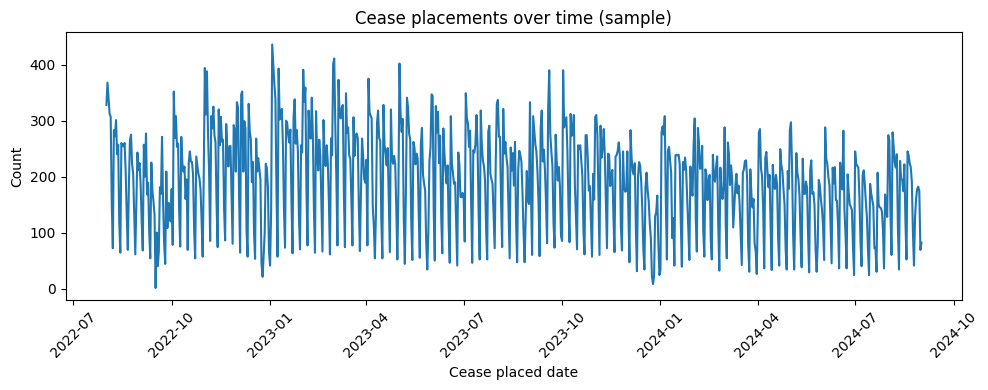

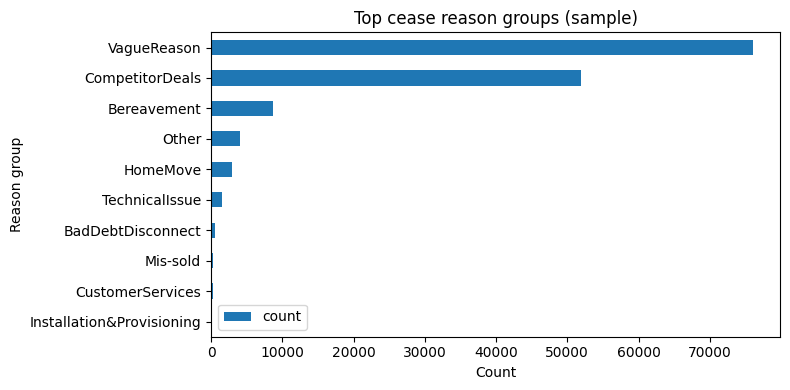

In [22]:
# Cease trends and reasons
cease_daily = cease.groupby('cease_placed_date', dropna=False).size().rename('cease_count').reset_index()
reason_counts = cease['reason_description_insight'].value_counts(dropna=False).rename_axis('reason_description_insight').reset_index(name='count')

display(reason_counts.head(10))

fig, ax = plt.subplots(figsize=(10,4))
cease_daily = cease_daily.sort_values('cease_placed_date')
ax.plot(cease_daily['cease_placed_date'], cease_daily['cease_count'])
ax.set_title('Cease placements over time (sample)')
ax.set_xlabel('Cease placed date')
ax.set_ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(output_dir / 'cease_trends.png', dpi=150)
plt.show()

fig, ax = plt.subplots(figsize=(8,4))
reason_counts.head(10).sort_values('count').plot(kind='barh', x='reason_description_insight', y='count', ax=ax)
ax.set_title('Top cease reason groups (sample)')
ax.set_xlabel('Count')
ax.set_ylabel('Reason group')
plt.tight_layout()
plt.savefig(output_dir / 'top_cease_reason.png', dpi=150)
plt.show()


<b> Observation </b>

<b> Cease volumes are highly cyclical </b>

- The time-series line shows a strong repeating pattern (regular peaks and dips), which likely reflects weekly/operational seasonality.

- This means cease activity is not random — there is a clear temporal pattern that should be considered in modelling (e.g., day-of-week / week-based features).

<b> Overall cease levels appear to trend slightly downward over time </b>

- Earlier periods (around 2022–2023) show more frequent highs and higher peaks.

- By 2024, the values still fluctuate strongly, but the general level looks lower on average than earlier periods.

### ******************************************************

<b> 2. Customer info dataset (contract, tenure, DD cancels, package)</b>

In [18]:

# Connect
catalog_db = duckdb.connect("UK_telecom.duckdb")

# Register customer parquet as a view (adjust path if needed)
customer_parquet = Path("../data/customer_info.parquet")

catalog_db.execute(f"""
    CREATE OR REPLACE VIEW customer_info AS
    SELECT *
    FROM read_parquet('{customer_parquet.as_posix()}')
""")

# Create churn feature view (SQL equivalent of your pandas feature engineering)
catalog_db.execute("""
    CREATE OR REPLACE VIEW customer_features AS
    SELECT
        *,
        (speed - line_speed) AS speed_gap,
        CASE
            WHEN speed > 0 THEN line_speed * 1.0 / speed
            ELSE NULL
        END AS speed_ratio,
        CASE
            WHEN ooc_days > 0 THEN 1 ELSE 0
        END AS is_out_of_contract,
        CASE
            WHEN ooc_days BETWEEN -30 AND 0 THEN 1 ELSE 0
        END AS is_near_contract_end,
        CASE
            WHEN dd_cancel_60_day > 0 THEN 1 ELSE 0
        END AS dd_cancel_flag_60d
    FROM customer_info
""")

print("Created view: customer_features")

Created view: customer_features


<b>Feature view from customer_info (snapshot-level)</b>

In [19]:
cat_profile = catalog_db.execute("""
    SELECT 'contract_status' AS column_name,
           COUNT(*) AS total_rows,
           SUM(CASE WHEN contract_status IS NULL THEN 1 ELSE 0 END) AS null_rows,
           COUNT(DISTINCT contract_status) AS distinct_values
    FROM customer_features
    UNION ALL
    SELECT 'technology',
           COUNT(*),
           SUM(CASE WHEN technology IS NULL THEN 1 ELSE 0 END),
           COUNT(DISTINCT technology)
    FROM customer_features
    UNION ALL
    SELECT 'sales_channel',
           COUNT(*),
           SUM(CASE WHEN sales_channel IS NULL THEN 1 ELSE 0 END),
           COUNT(DISTINCT sales_channel)
    FROM customer_features
    UNION ALL
    SELECT 'crm_package_name',
           COUNT(*),
           SUM(CASE WHEN crm_package_name IS NULL THEN 1 ELSE 0 END),
           COUNT(DISTINCT crm_package_name)
    FROM customer_features
""").df()

cat_profile

,column_name,total_rows,null_rows,distinct_values
0,contract_status,3545538,0.0,6
1,technology,3545538,0.0,4
2,sales_channel,3545538,0.0,13
3,crm_package_name,3545538,0.0,64


<b> Top values per categorical column</b>

In [20]:
top_contract_status = catalog_db.execute("""
    SELECT contract_status, COUNT(*) AS cnt
    FROM customer_features
    GROUP BY contract_status
    ORDER BY cnt DESC
    LIMIT 10
""").df()

top_technology = catalog_db.execute("""
    SELECT technology, COUNT(*) AS cnt
    FROM customer_features
    GROUP BY technology
    ORDER BY cnt DESC
    LIMIT 10
""").df()

top_sales_channel = catalog_db.execute("""
    SELECT sales_channel, COUNT(*) AS cnt
    FROM customer_features
    GROUP BY sales_channel
    ORDER BY cnt DESC
    LIMIT 10
""").df()

top_crm_package = catalog_db.execute("""
    SELECT crm_package_name, COUNT(*) AS cnt
    FROM customer_features
    GROUP BY crm_package_name
    ORDER BY cnt DESC
    LIMIT 10
""").df()

print("Top contract_status")
display(top_contract_status)

print("Top technology")
display(top_technology)

print("Top sales_channel")
display(top_sales_channel)

print("Top crm_package_name")
display(top_crm_package)

Top contract_status


,contract_status,cnt
0,02 In Contract,1673081
1,06 OOC,980655
2,03 Soon to be OOC,297006
3,01 Early Contract,280128
4,05 Newly OOC,194105
5,04 Coming OOC,120563


Top technology


,technology,cnt
0,FTTC,3012289
1,MPF,346213
2,GFAST,178152
3,FTTP,8884


Top sales_channel


,sales_channel,cnt
0,Online - Affiliate,885088
1,Migrated Customer,590712
2,Inbound,465320
3,Unknown,433451
4,Partners,297457
5,Online - Search,289458
6,Retail,221620
7,Online - Ambient,182657
8,Webchat,79986
9,Field,39498


Top crm_package_name


,crm_package_name,cnt
0,Fibre 65 (FTTC-OR),1784809
1,Fibre 35 (FTTC-OR),911961
2,Faster Fibre,311508
3,Fast Broadband,251250
4,Fibre 150 (GFast-OR),170048
5,Broadband Only (SMPF),10590
6,BB (SMPF),10448
7,Fibre 150 VoIP (FTTP-CF),8883
8,Fibre 250 (GFast-OR),8104
9,SimplyBroadband,6765


<b>3. Usage data (Behavioural Patterns) </b>

,call_type,n_calls,avg_talk_s,avg_hold_s,avg_hold_ratio
0,Tech,171942,887.754621,192.088326,0.296852
1,CS&B,167117,665.655481,172.260638,0.348631
2,Loyalty,144269,653.617978,254.498222,0.562061
3,Customer Finance,71105,428.256269,118.686112,0.396131
4,FTTP,43926,672.355120,236.907230,0.497536
5,null,17948,72.919044,6.239915,0.112430
6,Other,5385,808.668338,79.771216,0.124971
7,Order Management,4422,383.581411,104.730439,0.431668
8,Complaints,1504,1108.925532,135.269282,0.121306
9,TTB - Sales,369,240.520325,47.926829,0.298950


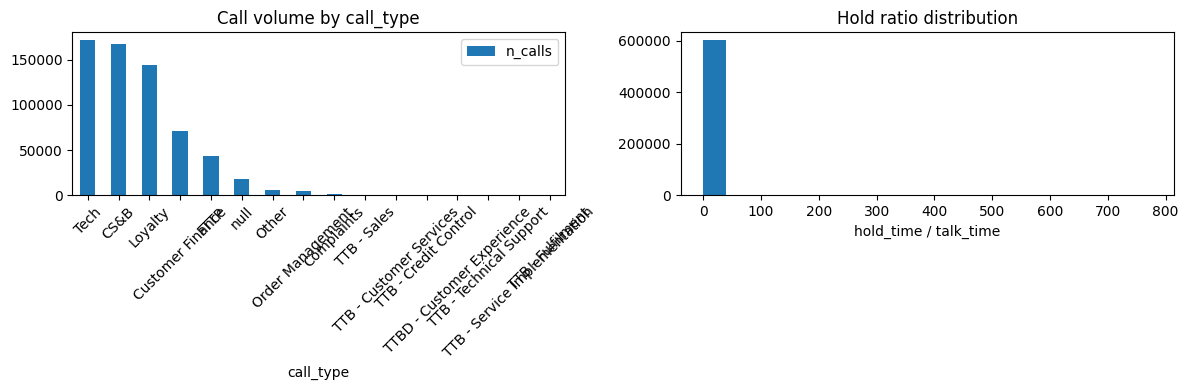

In [25]:


# 1) Force numeric conversion (invalid values become NaN)
calls['talk_time_seconds'] = pd.to_numeric(calls['talk_time_seconds'], errors='coerce')
calls['hold_time_seconds'] = pd.to_numeric(calls['hold_time_seconds'], errors='coerce')

# 2) Create hold_ratio safely (avoid divide-by-zero)
calls['hold_ratio'] = np.where(
    calls['talk_time_seconds'].fillna(0) > 0,
    calls['hold_time_seconds'] / calls['talk_time_seconds'],
    np.nan
)

# 3) Aggregate call summary
call_summary = (
    calls.groupby('call_type', dropna=False)
    .agg(
        n_calls=('unique_customer_identifier', 'size'),
        avg_talk_s=('talk_time_seconds', 'mean'),
        avg_hold_s=('hold_time_seconds', 'mean'),
        avg_hold_ratio=('hold_ratio', 'mean')
    )
    .sort_values('n_calls', ascending=False)
    .reset_index()
)

display(call_summary)

# 4) Plot
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

call_summary.plot(
    kind='bar',
    x='call_type',
    y='n_calls',
    ax=axes[0],
    title='Call volume by call_type'
)
axes[0].tick_params(axis='x', rotation=45)
axes[0].set_xlabel('call_type')

axes[1].hist(calls['hold_ratio'].dropna(), bins=20)
axes[1].set_title('Hold ratio distribution')
axes[1].set_xlabel('hold_time / talk_time')

plt.tight_layout()
plt.savefig(output_dir / 'calls_eda.png', dpi=150)
plt.show()

<b> Observation </b>


<b> Call volumes are concentrated in a few call types </b> 

- Tech, CS&B, and Loyalty are the dominant call types by a wide margin.

- This suggests most customer contact activity is concentrated in support/service and retention-related interactions.

<b>  A steep drop-off after the top categories </b>

- After the top 3–4 call types, volumes fall sharply.

- Several categories have very low volumes, which may be:

        - niche operational queues, or

        - inconsistent labels / fragmented call type naming.

<b> null appears as a call_type category </b>

- The presence of a visible null category means some records are missing call type classification.

- This is a data quality issue and should be addressed, especially if call_type is used as a churn feature